In [1]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType
from graphframes import *

In [2]:
# Nomes de aquivos e pastas
checkpoint_dir = 'graphframes_cps_30m'
parquet_dir_name = 'output/embeddings_nome_30m'
parquet_nodes  = 'dataset/grapho/nodes_30m'
parquet_edges = 'dataset/grapho/edges_30m'

In [3]:
spark = SparkSession.builder \
            .appName("gera_arvore30") \
            .getOrCreate()

sc = spark.sparkContext
sc.setCheckpointDir(checkpoint_dir)

23/12/12 23:00:08 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [5]:
# Carrega nodes
nodes = spark.read.parquet(parquet_nodes)
# Carrega edges
edges = spark.read.parquet(parquet_edges)
# Carrega embeddings
embeddings = spark.read.parquet(parquet_dir_name)
# Criando o grafo de relacionamento empresas->socios
g = GraphFrame(nodes, edges)

In [23]:
def generate_filter_string(id_list):
    filter_string = " OR ".join([f"(a.id = '{id}') OR (b.id = '{id}')" for id in id_list])
    return filter_string

In [31]:
def get_vertices_edges_by_ids(g, id_list):
    pFind = "(a)-[e]->(b)"
    pFilter = generate_filter_string(id_list)

    # Filtrar as arestas com base na lista de IDs
    edges = g.find(pFind).filter(pFilter).select("e.*")

    # Selecionar vértices distintos relacionados às arestas
    v = edges.select("src").union(edges.select("dst")).distinct()

    # Obter os vértices correspondentes às arestas filtradas
    vertices = g.vertices.join(v, g.vertices["id"] == v["src"], "inner").select(g.vertices["*"])

    return vertices, edges

In [32]:
# chaves: 03235791, 73178600, 01354636
id_list = ['19322044']
vertices, edges = get_vertices_edges_by_ids(g, id_list)
## Aciona ao edge o tipo de ligação 1-natural 2-sugerida
edges=edges.withColumn("id_tipoRel", lit(1))

In [33]:
# Converter os DataFrames do PySpark para DataFrames do Pandas
pandas_vertices = vertices.toPandas()
pandas_edges = edges.toPandas()

ERROR:root:Exception while sending command.                                     
Traceback (most recent call last):
  File "/home/chico/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/chico/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/chico/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
/home/chico/spark/python/pyspark/context.py:657: RuntimeWarning: Unable to cleanly shutdown Spark JVM process. It is possible that the process has crashed, been killed or may also be in a z

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def plot_custom_graph(pandas_vertices, pandas_edges, title="Graph"):
    # Criar um grafo direcionado NetworkX
    G = nx.DiGraph()

    # Adicionar vértices e atribuir cores com base em 'id_tipoPessoa'
    cores_vertices = pandas_vertices.set_index('id')['id_tipoPessoa'].to_dict()
    G.add_nodes_from(pandas_vertices["id"].tolist())

    # Adicionar arestas e atribuir cores com base em 'id_tipoRel'
    cores_arestas = pandas_edges.set_index(['src', 'dst'])['id_tipoRel'].to_dict()
    G.add_edges_from(pandas_edges[["src", "dst"]].values)

    # Definir estilos e atributos visuais
    pos = nx.spectral_layout(G)  # Layout do grafo
    largura_arestas = 1  # Largura das arestas

    # Plotar os vértices com cores baseadas em 'id_tipoPessoa'
    nx.draw_networkx_nodes(G, pos, node_color=[cores_vertices[n] for n in G.nodes()], cmap=plt.cm.tab10, node_size=300)

    # Plotar as arestas com cores baseadas em 'id_tipoRel'
    nx.draw_networkx_edges(G, pos, edge_color=[cores_arestas[(src, dst)] for src, dst in G.edges()], width=largura_arestas, alpha=0.5)

    # Adicionar labels para 'id_tipoPessoa' igual a 1
    labels = {n: n if cores_vertices[n] == 1 else '' for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10)

    # Mostrar o grafo com um layout mais bonito e título personalizado
    plt.tight_layout()
    plt.axis('off')
    plt.title(title)  # Define o título do gráfico
    plt.show()

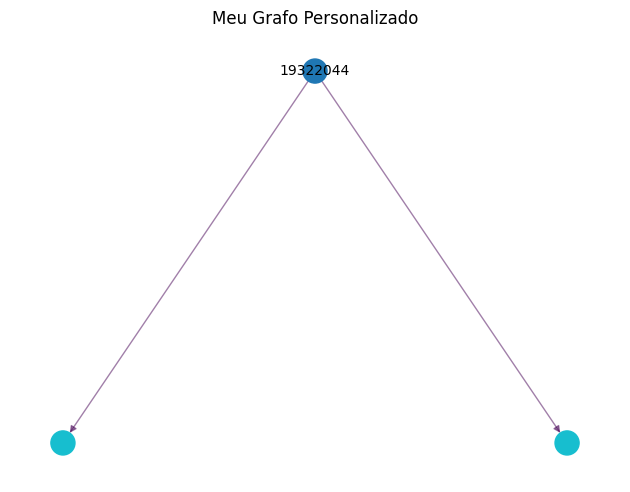

In [30]:
plot_custom_graph(pandas_vertices, pandas_edges, title="Meu Grafo Personalizado")

In [ ]:
spark.stop()